In [1]:
import numpy as np
import stl
import pulp as plp
from stl import mesh
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import pyro
import pyro.distributions as dist
import pyro.contrib.examples.util  # patches torchvision
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import matplotlib.pyplot as plt

/home/cyberguli/.conda/envs/sissa/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def calculate_angle(x,y,z):
        return np.arccos(np.sum((x-y)*(x-z))/(np.linalg.norm(x-y)*np.linalg.norm(x-z)))
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3
def unique(list1):
 
    # initialize a null list
    unique_list = []
     
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    
    return unique_list
                   

In [3]:
def createRIMD(reference,deformed):
    print('getting reference')
    #gets point and implicit neighbouroods of reference
    your_mesh0 = mesh.Mesh.from_file(reference)
    temp0=your_mesh0.data[0][1]
    for i in range(1,len(your_mesh0.data)):
        temp0=np.concatenate((temp0,your_mesh0.data[i][1]), axis=0)
    Pointset0 = np.unique(temp0, axis=0)
    neigh0=[]
    N=len(Pointset0)
    for i in range(len(Pointset0)):
        lst=[]
        for j in range(len(your_mesh0.data)):
            if Pointset0[i].tolist() in your_mesh0.data[j][1].tolist():
                for k in range(3):
                    if Pointset0[i].tolist()!=your_mesh0.data[j][1][k].tolist():
                        lst.append(your_mesh0.data[j][1][k].tolist())
        lst=unique(lst)
        neigh0.append(lst)
    neigh0=unique(neigh0)
    #gets point and and neigh of deformed
    print('getting deformed')
    your_mesh1 = mesh.Mesh.from_file(deformed)
    temp1=your_mesh1.data[0][1]
    for i in range(1,len(your_mesh1.data)):
        temp1=np.concatenate((temp1,your_mesh1.data[i][1]), axis=0)
    Pointset1 = np.unique(temp1, axis=0)
    neigh1=[]
    for i in range(N):
        lst=[]
        for j in range(len(your_mesh1.data)):
            if Pointset1[i].tolist() in your_mesh1.data[j][1].tolist():
                for k in range(3):
                    if Pointset1[i].tolist()!=your_mesh1.data[j][1][k].tolist():
                        lst.append(your_mesh1.data[j][1][k].tolist())
                        lst=unique(lst)
        neigh1.append(lst)
        neigh1=unique(neigh1)
     #calculates the matrix of the angles
    C=np.zeros([N,N])
    for i in range(N):
        for j in range(N):
            if i!=j:
                temp=intersection(neigh0[i],neigh0[j])
                if len(temp)==2:
                    C[i,j]=abs(1/np.tan(calculate_angle(temp[0],Pointset0[i],Pointset0[j])))+abs(1/np.tan(calculate_angle(temp[1],Pointset0[i],Pointset0[j])))
    #calculates real neigh
    print('calculating real neigh')
    neigh=[1]*N
    for i in range(N):
        neigh[i]=[j for j in range(N) if C[i,j]!=0]
    print('calculating T')
    #calculates T
    T=np.zeros([N,3,3])
    for i in range(N):
        for a in range(3):
            for b in range(3):
                temp0=0
                temp1=0
                for j in neigh[i]: 
                        p0=Pointset0[i]-Pointset0[j]
                        p1=Pointset1[i]-Pointset1[j]
                        temp0=temp0+C[i,j]*p0[b]*p1[a]
                        temp1=temp1+C[i,j]*p0[b]*p0[b]
                T[i,a,b]=temp0/temp1
    T=np.nan_to_num(T,nan=1)
    R=np.zeros([N,3,3])
    S=np.zeros([N,3,3])
    dR=np.zeros([N,N,3,3])
    temp=np.zeros([N,3,3])
    print('calculating R and S')
    #calculates R and S
    for i in range(N):
        temp[i]=np.matmul(T[i].T,T[i])
        D,Q=np.linalg.eigh(temp[i])
        D=np.diag(D)**0.5
        D=np.nan_to_num(D,nan=1)
        S[i]=np.matmul(Q.T,np.matmul(D,Q))
        R[i]=np.matmul(T[i],np.linalg.inv(S[i]))
        R[i][R[i]==np.inf] = 999

    print('calculating RIMD')
    RIMDi0=S[0]
    for j in neigh[0]:
        dR[0][j]=np.matmul(R[0].T,R[j])
        RIMDi0=np.concatenate((dR[0,j],RIMDi0),axis=1)
    RIMD=RIMDi0
    for i in range(N):
        RIMDi=S[i]
        for j in neigh[i]:
            dR[i][j]=np.matmul(R[i].T,R[j])
            RIMDi=np.concatenate((dR[i,j],RIMDi),axis=1)
        RIMD=np.concatenate((RIMD,RIMDi),axis=1)
    M=len(RIMD[0,:])
    RIMD=RIMD.reshape(3*M)
    E=np.zeros([N,N,3])
    for i in range(N):
        for j in neigh[i]:
            E[i,j,:]=Pointset0[i]-Pointset0[j]
    shape=np.zeros([len(your_mesh0.data),3])
    for i in range(len(your_mesh0.data)):
        for k in range(3):
            for j in range(len(Pointset0)):
                if your_mesh0.data[i][1][k].tolist()==Pointset0[j].tolist():
                    shape[i,k]=j
                   
    
    return RIMD,neigh,E,C,shape

In [4]:
def create_STL(newRIMD,neigh,E,C,shape,name):
    newRIMD=newRIMD.reshape(3,int(len(newRIMD)/3))
    N=len(neigh)
    newS=np.zeros([N,3,3])
    newdR=np.zeros([N,N,3,3])
    k=0
    for i in range(len(neigh)):
        for j in neigh[i]:
            newdR[i,j]=np.exp(newRIMD[:,k:k+3])
            k=k+3
        newS[i]=newRIMD[:,k:k+3]

    newR=np.zeros([N,3,3])
    for i in range(N):
        newR[i,:,:]=np.eye(3)

    Energy=1
    Energyold=0
    while abs(Energy-Energyold)/abs(Energy)>0.03:
        opt_model = plp.LpProblem()
        Ctilde=np.zeros(N)
        for i in range(N):
            Ctilde[i]=1/len(neigh[i])
        x_vars  = {(i,h): plp.LpVariable(cat=plp.LpContinuous,  
               name="x_{0}_{1}".format(i,h)) for i in range(N) for h in range(3)}

        temp=np.zeros([N,3])
        for j in range(N):
            for k in neigh[j]:
                temp3=0
                temp0=0
                temp1=0
                for s in neigh[k]:
                    temp0=temp0+Ctilde[k]*np.matmul(newR[s],np.matmul(newdR[s,k],newS[k]))
                for i in neigh[j]:
                    temp1=temp1+Ctilde[j]*np.matmul(newR[i],np.matmul(newdR[i,j],newS[j]))
                temp3=temp3+C[j,k]*np.matmul(temp0+temp1,E[j,k])
            temp[j,:]=temp3

        constraints = {j : opt_model.addConstraint(
        plp.LpConstraint(
             e=plp.lpSum(C[j,k] * (x_vars[j,h]-x_vars[k,h] )for k in neigh[j]),
             sense=plp.LpConstraintEQ,
             rhs=temp[j][h],
             name="constraint_{0}_{1}".format(j,h)))
           for j in range(N) for h in range(3)}
        opt_model.solve(plp.PULP_CBC_CMD(msg=0))
        newP=np.zeros([N,3])
        newE=np.zeros([N,N,3])
        for i in range(N):
            for k in range(3):
                newP[i,k]=plp.value(x_vars[i,k])
        for i in range(N):
            for j in range(N):
                newE[i,j,:]=newP[i,:]-newP[j,:]
        Q=np.zeros([N,3,3])
        for i in range(N):
            temp1=0
            for j in neigh[i]:
                temp0=0
                for k in neigh[j]:
                    temp0=temp0+C[j,k]*np.outer(E[j,k],newE[j,k].T)
                temp1=temp1+Ctilde[j]*np.matmul(newdR[i,j],np.matmul(newS[i],temp0))
            Q[i]=temp1
            U, s, Vh = np.linalg.svd(Q[i])
            newR[i]=np.matmul(U,Vh)
        Energyold=Energy
        Energy=0
        for i in range(N):
            temp1=0
            for j in neigh[i]:
                temp0=0
                for k in neigh[j]:
                    temp0=temp0+C[j,k]*np.linalg.norm(newE[j,k]-np.matmul(np.matmul(newR[i],newdR[i,j]),np.matmul(newS[j],E[j,k])))**2
                temp1=temp1+Ctilde[j]*temp0
            Energy=Energy+temp1

    shape=shape.astype(np.int64)
    newmesh = np.zeros(len(shape), dtype=mesh.Mesh.dtype)
    for i in range(len(shape)):
        newmesh['vectors'][i]=np.array([newP[j].tolist() for j in shape[i].tolist()])
    mesh.Mesh(newmesh).save(name, mode=stl.Mode.ASCII)  

In [5]:
RIMD,neigh,E,C,shape=createRIMD('cube.stl','Parallelepiped.stl')
def pseudonormalize(data,a):
    return 2*a*(data-np.min(data))/(np.max(data)-np.min(data))-a,np.max(RIMD),np.min(RIMD)

RIMDtilde,Max,Min=pseudonormalize(RIMD,0.9)


getting reference
getting deformed
calculating real neigh
calculating T
calculating R and S
calculating RIMD


In [6]:
N=432
class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super().__init__()
        # setup the two linear transformations used
        self.fc1 = nn.Linear(z_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, N)
        # setup the non-linearities
        self.softplus = nn.Softplus()
        self.tanh = nn.Tanh()

    def forward(self, z):
        # define the forward computation on the latent z
        # first compute the hidden units
        hidden = self.softplus(self.fc1(z))
        # return the parameter for the output Bernoulli
        # each is of size batch_size x 784
        loc_img = self.tanh(self.fc21(hidden))
        return loc_img

class Encoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super().__init__()
        # setup the three linear transformations used
        self.fc1 = nn.Linear(N,hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        self.fc22 = nn.Linear(hidden_dim, z_dim)
        # setup the non-linearities
        self.softplus = nn.Softplus()

    def forward(self, x):
        x = x.reshape(N)
        # compute the hidden units
        hidden = self.softplus(self.fc1(x))
        # then return a mean vector and a (positive) square root covariance
        # each of size batch_size x z_dim
        z_loc = self.fc21(hidden)
        z_scale = torch.exp(self.fc22(hidden))
        return z_loc, z_scale

        
class VAE(nn.Module):
    # by default our latent space is 50-dimensional
    # and we use 400 hidden units
    def __init__(self, z_dim=5, hidden_dim=5, use_cuda=False):
        super().__init__()
        # create the encoder and decoder networks
        self.encoder = Encoder(z_dim, hidden_dim)
        self.decoder = Decoder(z_dim, hidden_dim)

        if use_cuda:
            # calling cuda() here will put all the parameters of
            # the encoder and decoder networks into gpu memory
            self.cuda()
        self.use_cuda = use_cuda
        self.z_dim = z_dim

    # define the model p(x|z)p(z)
    def model(self, x):
        # register PyTorch module `decoder` with Pyro
        pyro.module("decoder", self.decoder)
        with pyro.plate("data", x.shape[0]):
            # setup hyperparameters for prior p(z)
            z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
            # sample from prior (value will be sampled by guide when computing the ELBO)
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            # decode the latent code z
            loc_img = self.decoder(z)
            pyro.sample("obs", dist.AffineBeta(loc_img+1,1-loc_img,-1,2).to_event(1), obs=x)
            
    # define the guide (i.e. variational distribution) q(z|x)
    def guide(self, x):
        # register PyTorch module `encoder` with Pyro
        pyro.module("encoder", self.encoder)
        with pyro.plate("data", x.shape[0]):
            # use the encoder to get the parameters used to define q(z|x)
            z_loc, z_scale = self.encoder(x)
            # sample the latent code z
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            
    def fitted(self, x):
        # encode image x
        z_loc, z_scale = self.encoder(x)
        # sample in latent space
        z = dist.Normal(z_loc, z_scale).sample()
        # decode the image (note we don't sample in image space)
        loc_img = self.decoder(z)
        return loc_img

def train(svi, train_set, use_cuda=False):
    # initialize loss accumulator
    epoch_loss = 0.
    # do a training epoch over each mini-batch x returned
    # by the data loader
    for x in train_set:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # do ELBO gradient and accumulate loss
        epoch_loss += svi.step(x)
        
    # return epoch loss
    normalizer_train = len(train_set)
    total_epoch_loss_train = epoch_loss / normalizer_train
    return total_epoch_loss_train

def evaluate(svi, test_set, use_cuda=False):

    # initialize loss accumulator
    test_loss = 0.
    # compute the loss over the entire test set
    for x in test_set:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # compute ELBO estimate and accumulate loss
        test_loss += svi.evaluate_loss(x)

        hello=vae.fitted(x)
        
    return hello



0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
tensor(242.3925, dtype=torch.float64)
tensor(0.0508, dtype=torch.float64, grad_fn=<DivBackward0>)


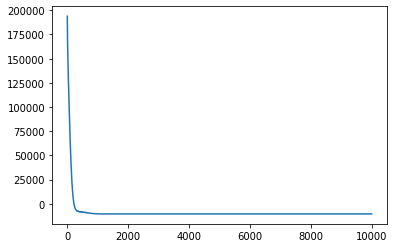

In [7]:
# Run options
LEARNING_RATE = 1.0e-3
USE_CUDA = False
# Run only for a single iteration for testing
NUM_EPOCHS = 100
TEST_FREQUENCY = 10

train_loader=[]
train_loader.append(torch.tensor(RIMDtilde).float())
test_loader=train_loader
# clear param store
pyro.clear_param_store()

# setup the VAE
vae = VAE(use_cuda=USE_CUDA)

# setup the optimizer
adam_args = {"lr": LEARNING_RATE}
optimizer = Adam(adam_args)

# setup the inference algorithm
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

train_elbo = []
test_elbo = []
error=[]
# training loop
for epoch in range(NUM_EPOCHS):
    total_epoch_loss_train = train(svi, train_loader, use_cuda=USE_CUDA)
    train_elbo.append(-total_epoch_loss_train)
    error.append(total_epoch_loss_train)
    #print("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))
    if epoch%100==0:
        print(epoch)
'''
    if epoch % TEST_FREQUENCY == 0:
        # report test diagnostics
        total_epoch_loss_test = evaluate(svi, test_loader, use_cuda=USE_CUDA)
        test_elbo.append(-total_epoch_loss_test)
        print("[epoch %03d] average test loss: %.4f" % (epoch, total_epoch_loss_test))
'''
plt.plot(error)
p
print(torch.sum(torch.tensor(RIMDtilde)**2))
print(torch.sum((torch.tensor(RIMDtilde)-evaluate(svi,train_loader,False))**2)/len(RIMDtilde))

In [11]:
newRIMDtilde=evaluate(svi,train_loader,False)
newRIMDtilde=newRIMDtilde.detach().numpy()
newRIMDtilde,*_=pseudonormalize(newRIMDtilde,0.9)
def pseudodenormalize(data,a,Max,min):
    return (data+a)/(2*a)*(Max-Min)-Min

newRIMD=pseudodenormalize(newRIMDtilde,0.9,Max,Min)
print(newRIMD)

[9.9994171e-01 2.2285515e-04 2.2749107e-04 1.0000648e+00 5.2047491e-16
 2.2808711e-04 1.0000718e+00 2.1868282e-04 2.2100078e-04 1.9999163e+00
 2.1702715e-04 2.2676257e-04 1.0002559e+00 3.4312409e-04 2.2722616e-04
 1.0000688e+00 6.5830018e-04 2.2259024e-04 1.0002522e+00 2.2060343e-04
 2.2855071e-04 1.9999123e+00 2.2000738e-04 2.1537146e-04 9.9978876e-01
 2.1841792e-04 2.1947756e-04 1.0000632e+00 2.1881529e-04 2.2331874e-04
 9.9996746e-01 2.2590160e-04 2.2504065e-04 9.9997658e-01 2.2040473e-04
 2.2464329e-04 1.0000615e+00 2.2331874e-04 2.1583505e-04 1.0000651e+00
 2.2576915e-04 2.2464329e-04 1.9999106e+00 2.2285515e-04 2.1914642e-04
 1.0000603e+00 2.1682846e-04 2.2259024e-04 1.0000606e+00 2.0027161e-04
 2.2663012e-04 1.0000753e+00 2.1570259e-04 2.2192797e-04 1.0000826e+00
 2.1974246e-04 2.1888151e-04 1.0000672e+00 2.2696125e-04 2.1782187e-04
 1.0001092e+00 2.2133192e-04 2.1669600e-04 1.9999554e+00 2.2179552e-04
 2.2676257e-04 1.0000685e+00 2.1980869e-04 2.2040473e-04 1.0002731e+00
 2.231

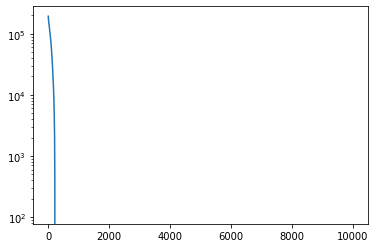

In [12]:
plt.semilogy(error)

In [9]:
create_STL(newRIMD,neigh,E,C,shape,'newmesh.stl')


In [10]:
your_mesh0 = mesh.Mesh.from_file("cube.stl")
your_mesh1 = mesh.Mesh.from_file("Parallelepiped.stl")
your_mesh2 = mesh.Mesh.from_file("newmesh.stl")

print(len(your_mesh0))
print(len(your_mesh1))
print(len(your_mesh2))

12
12
12
